In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow
import cv2
from google.colab import files
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [3]:
try:
  shutil.rmtree('/content/sample_data')
except:
  pass

In [4]:
!wget -q "https://iitk-my.sharepoint.com/:u:/g/personal/varunr21_iitk_ac_in/EX3NyyJYkv1MioxeWD5JdcUBAyB9zzBBfpTdDrg41hLnww?e=1kIdTQ&download=1" -P "/content/" -O "Input.zip"
!wget -q "https://iitk-my.sharepoint.com/:u:/g/personal/varunr21_iitk_ac_in/Eb6Ch3nfZ_9MqmJkCu4Vqb0B5vd_SAaHxt3Zs6kWVzmntQ?e=5YB4bh&download=1" -P "/content/" -O "Output.zip"

In [5]:
!unzip -q Input.zip 
!unzip -q Output.zip 
history = []

warning [Input.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [Input.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #85630).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)
warning [Output.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [Output.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #85630).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [6]:
from scipy.io import loadmat

def Load(output,idx):
  output = loadmat(output[idx])
  output = np.array(output['temp_u'])
  return output

In [7]:
def Stack(input,idx):
  sample=[]  
  im_0 = cv2.cvtColor(cv2.imread(input[0]),cv2.COLOR_RGB2GRAY) 
  im = cv2.cvtColor(cv2.imread(input[idx]),cv2.COLOR_RGB2GRAY)
  sample = np.stack((im_0,im),axis=0)
  return sample

In [8]:
k=0
dir='/content/Input2/Training'
path='/content/Training_Input'
os.mkdir(path)
for folder in sorted(os.listdir(dir)):
  root=os.path.join(dir,folder)
  list_path = [os.path.join(root, file) for file in sorted(os.listdir(root))]
  for i in range(len(list_path)):
    filename = 'Input_%06d' % (k)
    img=Stack(list_path,i)
    name=os.path.join(path,filename)
    np.save(name,img)
    k=k+1

In [9]:
k=0
dir='/content/Output2/Train'
path='/content/Training_Output'
os.mkdir(path)
for folder in sorted(os.listdir(dir)):
  root=os.path.join(dir,folder)
  list_path = [os.path.join(root, file) for file in sorted(os.listdir(root))]
  for i in range(len(list_path)):
    filename = 'Output_%06d' % (k)
    u=Load(list_path,i)
    name=os.path.join(path,filename)
    np.save(name,u)
    k=k+1

In [10]:
Input_dir='/content/Training_Input'
Output_dir='/content/Training_Output'

input_files = [os.path.join(Input_dir, file) for file in sorted(os.listdir(Input_dir))]
output_files = [os.path.join(Output_dir, file) for file in sorted(os.listdir(Output_dir))]

In [11]:
class StackDataset(Dataset):
  def __init__(self, input, output, transform = None):
    self.input = input
    self.output = output
    self.transform = transform
  
  def __len__(self):
    return len(self.input)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.cpu().detach().numpy()

    sample = [np.load(self.input[idx]),np.load(self.output[idx])]
      
    if self.transform:
      sample = self.transform(sample)

    return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        input, output = sample

        return torch.from_numpy(input),torch.from_numpy(output)

In [12]:
dataset = StackDataset(input= input_files, 
                       output = output_files, 
                       transform=ToTensor())

for i in range(len(dataset)):
    input,output = dataset[i]

    print(i, 
          type(input),
          input.size(), 
          output.size())

    if i == 3:
        break

0 <class 'torch.Tensor'> torch.Size([2, 48, 48]) torch.Size([48, 48])
1 <class 'torch.Tensor'> torch.Size([2, 48, 48]) torch.Size([48, 48])
2 <class 'torch.Tensor'> torch.Size([2, 48, 48]) torch.Size([48, 48])
3 <class 'torch.Tensor'> torch.Size([2, 48, 48]) torch.Size([48, 48])


In [13]:
random_seed=42
torch.manual_seed(random_seed)

In [14]:
val_size = 15000
train_size = len(dataset)-val_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(69973, 15000)

In [15]:
batch_size =300

In [16]:
train_dl = DataLoader(train_ds,batch_size,shuffle = True,num_workers = 2,pin_memory = True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers = 2,pin_memory = True)

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DataDeviceLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        return len(self.dl)

In [29]:
EPE=nn.L1Loss()

In [30]:
class FlowBase(nn.Module):
    
    def training_step(self,batch):
        images,u = batch
        u = u[:,None,:,:]
        out = self(images)
        loss = EPE(out,u)*1e5
        return loss
    
    def validation_step(self,batch):
        images,u = batch
        u = u[:,None,:,:]
        out=self(images)
        loss = EPE(out,u)*1e5
        return {'val_loss':loss}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss  = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

In [31]:
class FlowNetS(FlowBase):
    
    def __init__(self):
        super().__init__()
        self.conv1   = nn.Conv2d( 2,   8, kernel_size=7, stride=1,padding='same')
        self.conv2   = nn.Conv2d( 8,  16, kernel_size=5, stride=2,padding = 2)
        self.conv3   = nn.Conv2d(16,  32, kernel_size=3, stride=2,padding = 1)
        self.conv4   = nn.Conv2d(32,  64, kernel_size=3, stride=2,padding = 1)
     
        self.deconv1 = nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1)
        self.deconv3 = nn.ConvTranspose2d(48,24,kernel_size=3,stride=2,output_padding=1,padding=1)

        self.conv5   = nn.Conv2d(32,  16, kernel_size=3, stride=1, padding=1)
        self.conv6   = nn.Conv2d(16,  1, kernel_size=3, stride=1, padding=1)
        

    
    def forward(self, x):
      x = x.float() # 2x50x50
      x1 = F.leaky_relu(self.conv1(x)) # 8x50x50
      x2 = F.leaky_relu(self.conv2(x1)) # 16x50x50
      x3 = F.leaky_relu(self.conv3(x2)) # 32x50x50
      x4 = F.leaky_relu(self.conv4(x3)) # 64x50x50
      x5 = F.leaky_relu(self.deconv1(x4)) # 32x50x50 + 32x50x50
      x6 = F.leaky_relu(self.deconv2(torch.cat([x5,x3],1))) # 32x50x50 + 16x50x50
      x7 = F.leaky_relu(self.deconv3(torch.cat([x6,x2],1))) # 24x50x50 + 8x50x50
      x8 = F.leaky_relu(self.conv5(torch.cat([x7,x1],1))) # 16x50x50
      xout = self.conv6(x8) # 1x50x50
    
      return xout.double()

In [21]:
model = FlowNetS()
model

FlowNetS(
  (conv1): Conv2d(2, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [22]:
for images,u in train_dl:
    print('Input Shape: ',images.shape)
    out = model(images)
    out=torch.squeeze(out,dim=1)
    print('Output Shape: ',out.shape,u.shape,u.dtype,out.dtype)
    break

Input Shape:  torch.Size([300, 2, 48, 48])
Output Shape:  torch.Size([300, 48, 48]) torch.Size([300, 48, 48]) torch.float64 torch.float64


In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl  = DataDeviceLoader(train_dl,device)
val_dl = DataDeviceLoader(val_dl,device)

In [25]:
to_device(model,device)

FlowNetS(
  (conv1): Conv2d(2, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [26]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.Adam,history=[]):
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    
    return history

In [27]:
model=to_device(FlowNetS(),device)

In [32]:
evaluate(model,val_dl)

{'val_loss': 129509.24295706266}

In [33]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [34]:
history = fit(num_epochs,lr,model,train_dl,val_dl,opt_func,history)

Epoch [0], train_loss: 7008.2535, val_loss: 1722.9275
Epoch [1], train_loss: 1371.8260, val_loss: 1043.9045
Epoch [2], train_loss: 862.0961, val_loss: 762.8245
Epoch [3], train_loss: 603.4117, val_loss: 544.1624
Epoch [4], train_loss: 451.8978, val_loss: 395.7077
Epoch [5], train_loss: 359.3613, val_loss: 316.0986
Epoch [6], train_loss: 294.2245, val_loss: 283.9340
Epoch [7], train_loss: 246.9156, val_loss: 231.0697
Epoch [8], train_loss: 213.1042, val_loss: 188.3499
Epoch [9], train_loss: 185.8849, val_loss: 168.2587
Epoch [10], train_loss: 165.9143, val_loss: 158.1566
Epoch [11], train_loss: 149.8884, val_loss: 142.3342
Epoch [12], train_loss: 136.8093, val_loss: 122.3352
Epoch [13], train_loss: 125.1826, val_loss: 118.2522
Epoch [14], train_loss: 115.8157, val_loss: 115.1719
Epoch [15], train_loss: 107.3862, val_loss: 103.2371
Epoch [16], train_loss: 99.4916, val_loss: 89.7632
Epoch [17], train_loss: 91.8007, val_loss: 92.4597
Epoch [18], train_loss: 85.7118, val_loss: 74.3484
Epoch

In [35]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses[1:], '-bx')
    plt.plot(val_losses[1:], '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. of epochs');

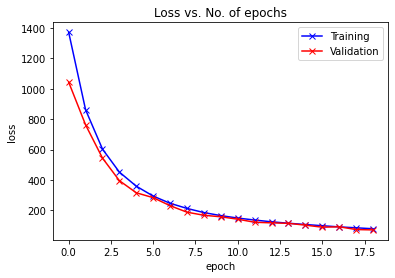

In [36]:
plot_losses(history)

In [ ]:
import pickle
with open("history", "wb") as fp:
  pickle.dump(history, fp)

In [ ]:
with open("history", "r") as fp:
  b = pickle.load(fp)

FileNotFoundError: ignored

In [ ]:
model = to_device(FlowNetS(),device)

NameError: ignored

In [ ]:
model.load_state_dict(torch.load('FlowNet_Mod.pth'))

NameError: ignored

In [53]:
k=0
dir='/content/Input2/Training/Video_012'
path='/content/Testing_Input'
#os.mkdir(path)
root=dir
list_path = [os.path.join(root, file) for file in sorted(os.listdir(root))]
for i in range(len(list_path)):
  filename = 'Input_%06d' % (k)
  img=Stack(list_path,i)
  name=os.path.join(path,filename)
  np.save(name,img)
  k=k+1

In [55]:
k=0
dir='/content/Output2/Train/Video_012'
path='/content/Test_Output'
#os.mkdir(path)
root=dir
list_path = [os.path.join(root, file) for file in sorted(os.listdir(root))]
for i in range(len(list_path)):
  filename = 'Output_%06d' % (k)
  u=Load(list_path,i)
  name=os.path.join(path,filename)
  np.save(name,u)
  k=k+1

In [56]:
Input_dir='/content/Testing_Input'
Output_dir='/content/Test_Output'

test_input_files = [os.path.join(Input_dir, file) for file in sorted(os.listdir(Input_dir))]
test_output_files = [os.path.join(Output_dir, file) for file in sorted(os.listdir(Output_dir))]

In [57]:
test_dataset = StackDataset(input= test_input_files, 
                       output= test_output_files, 
                       transform=ToTensor())

In [58]:
test_loader = DataDeviceLoader(DataLoader(test_dataset,batch_size*2),device)
result = evaluate(model,test_loader)
result

{'val_loss': 72.54978287435456}

In [59]:
output = []
for i in range(len(test_dataset)):
  input,_ = test_dataset[i]
  input = to_device(input,device)
  yb=model(input.unsqueeze(0)).cpu().detach().numpy()
  yb = np.mean(yb)
  output.append(yb)

print(len(output))

34772


In [60]:
disp_r = []
for i in range(len(test_dataset)):
  _,output_r = test_dataset[i]
  yb = np.mean(output_r.cpu().detach().numpy())
  disp_r.append(yb)

print(len(disp_r))

34772


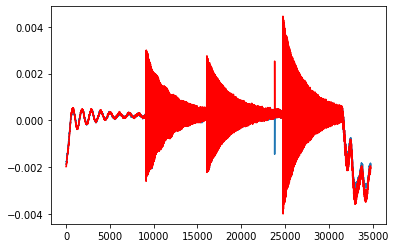

In [63]:
from statistics import mean
pixel_res=36
disp=[]
mod_disp=[]
for i in range(len(output)):
    disp.append((output[i]))
     
disp=disp - mean(disp)
disp_r=disp_r-mean(disp_r)
plt.plot(disp)
plt.plot(disp_r,'r')

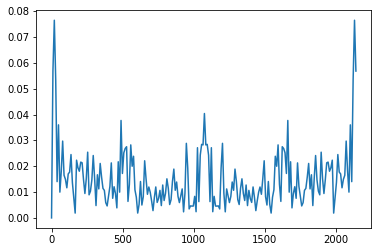

In [ ]:
from scipy.fft import fft
fs = 2142; 
X=list(disp)
X.append([0]*200)
time = (1/fs)*np.arange(0,len(disp)-1,1)
f = fs*np.linspace(0,1,len(X));
fft_X = (abs(fft(pixel_res*349*disp/1000,len(X))));
plt.plot(f,fft_X)


In [ ]:
torch.save(model.state_dict(),'subFlowNet.pth')